# 2.6. 概率
<font size=4>
简单地说，机器学习就是做出预测。

根据病人的临床病史，我们可能想预测他们在下一年心脏病发作的概率。 在飞机喷气发动机的异常检测中，我们想要评估一组发动机读数为正常运行情况的概率有多大。 在强化学习中，我们希望智能体（agent）能在一个环境中智能地行动。 这意味着我们需要考虑在每种可行的行为下获得高奖励的概率。 当我们建立推荐系统时，我们也需要考虑概率。 例如，假设我们为一家大型在线书店工作，我们可能希望估计某些用户购买特定图书的概率。 为此，我们需要使用概率学。 有完整的课程、专业、论文、职业、甚至院系，都致力于概率学的工作。 所以很自然地，我们在这部分的目标不是教授你整个科目。 相反，我们希望教给你在基础的概率知识，使你能够开始构建你的第一个深度学习模型， 以便你可以开始自己探索它。<br><br>

现在让我们更认真地考虑第一个例子：根据照片区分猫和狗。 这听起来可能很简单，但对于机器却可能是一个艰巨的挑战。 首先，问题的难度可能取决于图像的分辨率。<br>
    <img src='https://github.com/jhong-tao/s2dl/blob/master/ipynb/0-imgs/2.6.1.png?raw=true'><br>
如图所示，虽然人类很容易以$160\times 160$像素的分辨率识别猫和狗， 但它在$40\times 40$像素上变得具有挑战性，而且在$10\times 10$像素下几乎是不可能的。 换句话说，我们在很远的距离（从而降低分辨率）区分猫和狗的能力可能会变为猜测。 概率给了我们一种正式的途径来说明我们的确定性水平。 如果我们完全肯定图像是一只猫，我们说标签$y$是”猫”的概率，表示为$P(y="猫")$等于$1$。 如果我们没有证据表明$P(y="猫")$或$P(y="狗")$，那么我们可以说这两种可能性是相等的， 即$P(y="猫")=P(y="狗")=0.5$。 如果我们不十分确定图像描绘的是一只猫，我们可以将概率赋值为$0.5<P(y="猫")<1$。<br><br>
现在考虑第二个例子：给出一些天气监测数据，我们想预测明天北京下雨的概率。 如果是夏天，下雨的概率是0.5。
    <br><br>
在这两种情况下，我们都不确定结果，但这两种情况之间有一个关键区别。 在第一种情况中，图像实际上是狗或猫二选一。 在第二种情况下，结果实际上是一个随机的事件。 因此，概率是一种灵活的语言，用于说明我们的确定程度，并且它可以有效地应用于广泛的领域中。
</font>


## 2.6.1. 基本概率论
<font size=4>
    假设我们掷骰子，想知道看到$1$的几率有多大，而不是看到另一个数字。 如果骰子是公平的，那么所有六个结果$\left \{ 1,\dots,6 \right \}$都有相同的可能发生， 因此我们可以说$1$发生的概率为$\frac{1}{6}$。
    然而现实生活中，对于我们从工厂收到的真实骰子，我们需要检查它是否有瑕疵。 检查骰子的唯一方法是多次投掷并记录结果。 对于每个骰子，我们将观察到$\left \{ 1,\dots,6 \right \}$中的一个值。 对于每个值，一种自然的方法是将它出现的次数除以投掷的总次数， 即此事件（event）概率的估计值。 大数定律（law of large numbers）告诉我们： 随着投掷次数的增加，这个估计值会越来越接近真实的潜在概率。 让我们用代码试一试！
<br><br>
首先，我们导入必要的软件包。
</font>

In [24]:
%matplotlib inline
import torch
from torch.distributions import multinomial  # 导入多项分布
from d2l import torch as d2l
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

<font size=4>
    在统计学中，我们把从概率分布中抽取样本的过程称为抽样（sampling）。 笼统来说，可以把分布（distribution）看作是对事件的概率分配， 稍后我们将给出的更正式定义。 将概率分配给一些离散选择的分布称为多项分布（multinomial distribution）。<br><br>

为了抽取一个样本，即掷骰子，我们只需传入一个概率向量。 输出是另一个相同长度的向量：它在索引处的值是采样结果中出现的次数。
</font>

In [19]:
fair_probs = torch.ones([6])/6   # 创建骰子的6个面，每个面出现的几率是1/6
multinomial.Multinomial(1, fair_probs).sample()  # 做一次多项分布的采样，也就是投一次骰子，索引代表拆样结果

tensor([0., 0., 0., 1., 0., 0.])

<font size=4>
    在估计一个骰子的公平性时，我们希望从同一分布中生成多个样本。 如果用Python的for循环来完成这个任务，速度会慢得惊人。 因此我们使用深度学习框架的函数同时抽取多个样本，得到我们想要的任意形状的独立样本数组。
</font>

In [21]:
multinomial.Multinomial(10, fair_probs).sample()  # 做十次采样

tensor([1., 3., 2., 0., 1., 3.])

<font size=4>
    现在我们知道如何对骰子进行采样，我们可以模拟1000次投掷。 然后，我们可以统计1000次投掷后，每个数字被投中了多少次。 具体来说，我们计算相对频率，以作为真实概率的估计。
</font>

In [26]:
# 将结果存储为32位浮点数以进行除法
counts = multinomial.Multinomial(1000, fair_probs).sample()  # 做1000次采样
counts
counts/1000  # 相对频率作为估计值

tensor([152., 174., 185., 157., 188., 144.])

tensor([0.1520, 0.1740, 0.1850, 0.1570, 0.1880, 0.1440])

<font size=4>
    因为我们是从一个公平的骰子中生成的数据，我们知道每个结果都有真实的概率为$1/6$
 
， 大约是$0.167$，所以上面输出的估计值看起来不错。<br><br>

我们也可以看到这些概率如何随着时间的推移收敛到真实概率。 让我们进行500组实验，每组抽取10个样本。
</font>

In [55]:
# 每一组做10次采样，也就相当于投10次骰子；这样的操作做500次
counts = multinomial.Multinomial(10, fair_probs).sample((500,))  
counts
counts.shape
cum_counts = counts.cumsum(dim=0)  # 行上的累加和
cum_counts
# cum_counts.sum(dim=1, keepdims=True)   # 压缩到竖轴上的累加和
estimates = cum_counts/cum_counts.sum(dim=1, keepdims=True)  # 求每个点被取到的几率动态收敛过程
estimates

tensor([[2., 0., 3., 2., 1., 2.],
        [2., 4., 2., 2., 0., 0.],
        [2., 2., 1., 2., 1., 2.],
        ...,
        [1., 3., 1., 3., 1., 1.],
        [2., 2., 0., 3., 1., 2.],
        [0., 1., 3., 3., 1., 2.]])

torch.Size([500, 6])

tensor([[  2.,   0.,   3.,   2.,   1.,   2.],
        [  4.,   4.,   5.,   4.,   1.,   2.],
        [  6.,   6.,   6.,   6.,   2.,   4.],
        ...,
        [880., 840., 807., 832., 818., 803.],
        [882., 842., 807., 835., 819., 805.],
        [882., 843., 810., 838., 820., 807.]])

tensor([[0.2000, 0.0000, 0.3000, 0.2000, 0.1000, 0.2000],
        [0.2000, 0.2000, 0.2500, 0.2000, 0.0500, 0.1000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.0667, 0.1333],
        ...,
        [0.1767, 0.1687, 0.1620, 0.1671, 0.1643, 0.1612],
        [0.1768, 0.1687, 0.1617, 0.1673, 0.1641, 0.1613],
        [0.1764, 0.1686, 0.1620, 0.1676, 0.1640, 0.1614]])

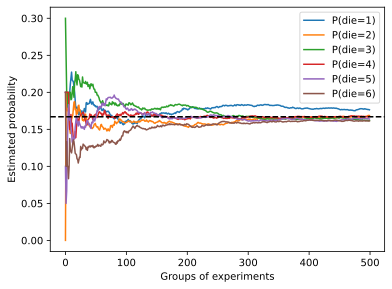

In [57]:
# 绘图,绘制投掷骰子的6个面每个面出现的几率的收敛过程
d2l.set_figsize((6, 4.5))
for i in range(6):
    d2l.plt.plot(estimates[:, i].numpy(),label=("P(die=" + str(i + 1) + ")"))
d2l.plt.axhline(y=0.167, color='black', linestyle='dashed')
d2l.plt.gca().set_xlabel('Groups of experiments')
d2l.plt.gca().set_ylabel('Estimated probability')
d2l.plt.legend();

<font size=4>
    每条实线对应于骰子的6个值中的一个，并给出骰子在每组实验后出现值的估计概率。 当我们通过更多的实验获得更多的数据时，这$6$条实体曲线向真实概率收敛。
</font>